In [48]:
!pip install inference inference-gpu supervision opencv-python
!pip install git+https://github.com/roboflow/sports.git

[notice] A new release of pip is available: 24.0 -> 24.3.1

[notice] To update, run: python.exe -m pip install --upgrade pip


  Running command git clone --filter=blob:none --quiet https://github.com/roboflow/sports.git 'C:\Users\isss1\AppData\Local\Temp\pip-req-build-z9vjl2lp'

  Cloning https://github.com/roboflow/sports.git to c:\users\isss1\appdata\local\temp\pip-req-build-z9vjl2lp

[notice] A new release of pip is available: 24.0 -> 24.3.1


[notice] To update, run: python.exe -m pip install --upgrade pip

  Resolved https://github.com/roboflow/sports.git to commit 06053616f1f8a8ae1fa936eb00dcdc2e4f888bb1

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/44.1 kB ? eta -:--:--
     -------------------------- ----------- 30.7/44.1 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 44.1/44.1 kB 546.6 kB/s eta 0:00:00
     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     ---------------------------------------- 41.5/41.5 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/11.0 MB 2.3 MB/s eta 0:00:05
    --------------------------------------- 0.2/11.0 MB 2.8 MB/s eta 0:00:04
   - -------------------------------------- 0.4/11.0 MB 3.0 MB/s eta 0:00:04
   - -------------------------------------- 0.5/11.0 MB 3.1 MB/s eta 0:00:04
   -- ------------------------------------- 0.7/11.0 MB 3.2 MB/s eta 0:00:04
   --- ------------------------------------ 0.9/11.0 MB 3.3

In [2]:
!pip install torch

   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.2/203.1 MB 3.1 MB/s eta 0:01:07
   ---------------------------------------- 0.2/203.1 MB 2.9 MB/s eta 0:01:11
   ---------------------------------------- 0.3/203.1 MB 2.5 MB/s eta 0:01:23
   ---------------------------------------- 0.4/203.1 MB 2.7 MB/s eta 0:01:16
   ---------------------------------------- 0.5/203.1 MB 2.7 MB/s eta 0:01:16
   ---------------------------------------- 0.6/203.1 MB 2.9 MB/s eta 0:01:11
   ---------------------------------------- 0.8/203.1 MB 2.8 MB/s eta 0:01:13
   ---------------------------------------- 0.9/203.1 MB 2.8 MB/s eta 0:01:13
   ---------------------------------------- 1.0/203.1 MB 2.8 MB/s eta 0:01:13
   ---------------------------------------- 1.1/203.1 MB 2.8 MB/s eta 0:01:12
   ---------------------------------------- 1.2/203.1 MB 3.0 MB/s eta 0:01:09



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. Training on GPU!")
else:
    print("CUDA is not available. Training on CPU.")

CUDA is not available. Training on CPU.


[10/29/24 10:25:37] WARNING  Your inference package version 0.23.0 is out of date! Please upgrade to ]8;id=520227;file://c:\Users\isss1\GitHub\soccer-computer-vision-analysis\soccer-env\Lib\site-packages\inference\core\__init__.py\__init__.py]8;;\:]8;id=967376;file://c:\Users\isss1\GitHub\soccer-computer-vision-analysis\soccer-env\Lib\site-packages\inference\core\__init__.py#41\41]8;;\
                             version 0.24.0 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[1195.,  367., 1238.,  459.],
       [  60.,  526.,  122.,  647.],
       [1656.,  580., 1726.,  701.],
       [1503.,  426., 1555.,  527.],
       [1095.,  461., 1138.,  566.],
       [ 857.,  439.,  914.,  535.],
       [ 756.,  382.,  803.,  481.],
       [ 850.,  344.,  891.,  427.],
       [ 800.,  317.,  843.,  387.],
       [1150.,  349., 1178.,  426.],
       [ 370.,  404.,  409.,  510.],
       [1321.,  412., 1350.,  505.],
       [1183.,  313., 1214.,  384.],
       [1459.,  389., 1501.,  483.],
       [1315.,  347., 1339.,  416.],
       [1045.,  419., 1081.,  478.],
       [1642.,  428., 1672.,  534.],
       [1051.,  365., 1072.,  433.],
       [ 747.,  420.,  770.,  442.]]), mask=None, confidence=array([0.93859369, 0.9361639 , 0.93506873, 0.92912686, 0.92835104,
       0.92403758, 0.92248756, 0.9132008 , 0.90408027, 0.89720261,
       0.89320207, 0.89172792, 0.88695693, 0.8834542 , 0.86871785,
       0.8426497 , 0.84187245, 0.79695284, 0.60329545]),

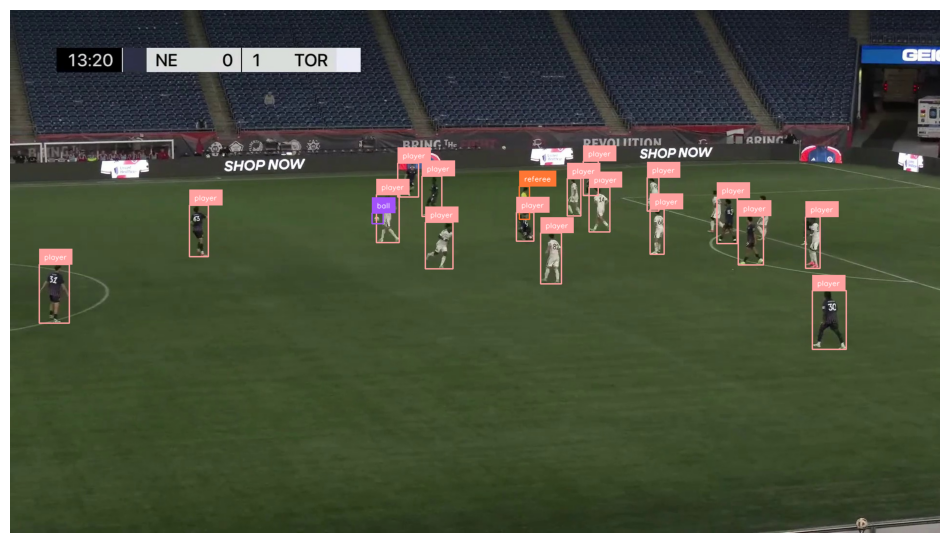

In [2]:
from inference import get_model
import supervision as sv
import cv2

# define the image url to use for inference
image_file = "images-object/frame600.jpg"
image = cv2.imread(image_file)

# load a pre-trained yolov8n model
objectModel = get_model(model_id="soccer-computer-vision-acffy/3")

# run inference on our chosen image, image can be a url, a numpy array, a PIL image, etc.

results = objectModel.infer(image)[0]

# load the results into the supervision Detections api
detections = sv.Detections.from_inference(results)

# create supervision annotators
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# annotate the image with our inference results
print(detections)

annotated_image = bounding_box_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# display the image
sv.plot_image(annotated_image)

In [71]:
import supervision as sv
from inference import get_model
import numpy as np

PITCH_CONFIDENCE_LEVEL = 0.7
KEYPOINT_CONFIDENCE_LEVEL = 0.6
KEYPOINT_DETECTION_MODEL_NAME = "soccer-field-detection-sbywb/7"

def getObjectDetections(frame, index):
    objectModel = get_model(model_id="soccer-computer-vision-acffy/3")
    result = objectModel.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    return detections

# Uses a keypoint detection model to return pitch keypoints
def getPitchKeypoints(image):
    keypointModel = get_model(model_id=KEYPOINT_DETECTION_MODEL_NAME)
    result = keypointModel.infer(image, confidence=PITCH_CONFIDENCE_LEVEL)[0]    
    keypoints = sv.KeyPoints.from_inference(result)
    
    return keypoints

def getKeypointsFilter(keypoints):
    filter = keypoints.confidence > KEYPOINT_CONFIDENCE_LEVEL
    
    return filter
    
def getFilteredKeypoints(keypoints, filter):
    xy = keypoints.xy[filter]
    confidence = keypoints.confidence[filter]
    filteredKeypoints = sv.KeyPoints(xy=xy[np.newaxis, ...], confidence=confidence[np.newaxis, ...])
    
    return filteredKeypoints

class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        if source.shape != target.shape:
            raise ValueError(
                "Source and target must have the same shape.")
        if source.shape[1] != 2:
            raise ValueError(
                f"Source and target points must be 2D coordinates. They are currently {source.shape} and {target.shape}.")

        source = source.astype(np.float32)
        target = target.astype(np.float32)

        self.m, _ = cv2.findHomography(source, target)
        if self.m is None:
            raise ValueError(
                "Homography matrix could not be calculated.")

    def transformPoints(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        if points.shape[1] != 2:
            raise ValueError("Points must be 2D coordinates.")

        points = points.reshape(-1, 1, 2).astype(np.float32)
        points = cv2.perspectiveTransform(points, self.m)
        
        return points.reshape(-1, 2).astype(np.float32)

In [94]:
from sports.configs.soccer import SoccerPitchConfiguration
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch

SOCCER_PITCH_CONFIG = SoccerPitchConfiguration()

# Perspective transformation
fileName = "images-pitch/frame35.jpg"
image = cv2.imread(fileName)
keypoints = getPitchKeypoints(image)

# FIXME: Need to re-arrange keypoints to the mapping associated with the soccer pitch configuration
# Can use this in the future
# https://github.com/roboflow/sports/blob/main/sports/configs/soccer.py

# Want to map my points (key) to their points (value)
keypointsMapping = {
    '1': 1,
    '2': 6,
    '3': 5,
    '4': 13,
    '5': 10,
    '6': 2,
    '7': 4,
    '8': 8,
    '9': 7,
    '10': 3,
    '11': 9,
    '12': 12,
    '13': 11,
    '14': 18,
    '15': 17,
    '16': 14,
    '17': 16,
    '18': 19,
    '19': 15,
    '20': 27,
    '21': 28,
    '22': 20,
    '23': 23,
    '24': 31,
    '25': 30,
    '26': 26,
    '27': 25,
    '28': 29,
    '29': 24,
    "30": 32,
    "31": 22,
    "32": 21,
    "33": 33,
    "34": 34,
    "35": 35,
    "36": 36
}

# Iterate throughe ach keypoint
keypointsXy = list(keypoints.xy[0])
updatedKeypointsXy = []

print(keypointsXy)
print(len(keypointsXy))
# FIXME: 
# keypoints = sv.KeyPoints(xy=np.array(updatedKeypointsXy)[np.newaxis, ...])

for i in range(len(keypointsXy)):
    updatedKeypointsXy.insert(keypointsMapping[str(i + 1)] - 1, keypointsXy[i])
    
print("Keypoints XY After Transformation")
print(updatedKeypointsXy)

filter = getKeypointsFilter(keypoints)


filteredKeypoints = getFilteredKeypoints(keypoints, filter)
objectDetections = getObjectDetections(image, None)

# Added this in as the pitch configuration only has 32 keypoints
# TODO: Investigate if this inclusion may be causing issues
keypointAdjustmentFilter = [filter[0][0:32]]
targetKeypoints = np.array(SOCCER_PITCH_CONFIG.vertices)[keypointAdjustmentFilter[0]]

print(f"The amount of filtered keypoints with a confidence level over {KEYPOINT_CONFIDENCE_LEVEL} is {filteredKeypoints.xy.shape[1]}.")


sourceXy = filteredKeypoints.xy[0].astype(np.float32)
targetXy = targetKeypoints.astype(np.float32)
print("Shapes")
print(sourceXy.shape)
print(targetXy.shape)

# Will need to adjust my keypoints mapping to conform with this

transformer = ViewTransformer(
    source=sourceXy,
    target=targetXy
)


BALL_CLASS_ID = 0
GOALKEEPER_CLASS_ID = 1
PLAYER_CLASS_ID = 2
REFEREE_CLASS_ID = 3

# Obtain class separated detections to denote them differently by colour
ballDetections = objectDetections[objectDetections.class_id == BALL_CLASS_ID]
goalkeeperDetections = objectDetections[objectDetections.class_id == GOALKEEPER_CLASS_ID]
playerDetections = objectDetections[objectDetections.class_id == PLAYER_CLASS_ID]
refereeDetections = objectDetections[objectDetections.class_id == REFEREE_CLASS_ID]

print("Detection Counts")
print(f"Ball: {len(ballDetections)}")
print(f"Goalkeepers: {len(goalkeeperDetections)}")
print(f"Players: {len(playerDetections)}")
print(f"Referees: {len(refereeDetections)}")

# Transforming detections for the homography matrix
ballCoords = transformer.transformPoints(points=ballDetections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER))
goalkeeperCoords = transformer.transformPoints(points=goalkeeperDetections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER))
playerCoords = transformer.transformPoints(points=playerDetections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER))
refereeCoords = transformer.transformPoints(points=refereeDetections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER))

print("Pre-transformed")
print(playerDetections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER))
print("After Transformation")
print(playerCoords)

# Output detections image, with keypoints and object detection
boundingBoxAnnotator = sv.BoxAnnotator()
labelAnnotator = sv.LabelAnnotator()
keypointAnnotator = sv.VertexAnnotator(radius=12, color=sv.Color.GREEN)
keypoint2Annotator = sv.VertexAnnotator(radius=12, color=sv.Color.RED)
lineAnnotator = sv.EdgeAnnotator(color=sv.Color.RED, thickness=2, edges=SOCCER_PITCH_CONFIG.edges)
    
objectLabels = [ f"{class_name} {confidence:.2f}" for class_name, confidence in zip(objectDetections['class_name'], objectDetections.confidence) ]


# annotate the image with our inference results
# Must use all 32 points for the edge annotator, according to the API
# footageImage = lineAnnotator.annotate(scene=image, key_points=targetKeypointsToShow)
footageImage = boundingBoxAnnotator.annotate(scene=image, detections=objectDetections)
footageImage = labelAnnotator.annotate(scene=footageImage, detections=objectDetections, labels=objectLabels)

# Plotting all available keypoints, but showing their confidence levels
footageImage = keypointAnnotator.annotate(footageImage, filteredKeypoints)

sv.plot_image(footageImage)

pitchImage = draw_pitch(SOCCER_PITCH_CONFIG)

annotatedPitch = draw_points_on_pitch(
    config=SOCCER_PITCH_CONFIG,
    xy=ballCoords,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.BLACK,
    radius=8,
    thickness=1,
    pitch=pitchImage
)

annotatedPitch = draw_points_on_pitch(
    config=SOCCER_PITCH_CONFIG,
    xy=goalkeeperCoords,
    face_color=sv.Color.GREEN,
    edge_color=sv.Color.BLACK,
    radius=8,
    thickness=1,
    pitch=annotatedPitch
)

annotatedPitch = draw_points_on_pitch(
    config=SOCCER_PITCH_CONFIG,
    xy=playerCoords,
    face_color=sv.Color.BLUE,
    edge_color=sv.Color.BLACK,
    radius=8,
    thickness=1,
    pitch=annotatedPitch
)

annotatedPitch = draw_points_on_pitch(
    config=SOCCER_PITCH_CONFIG,
    xy=refereeCoords,
    face_color=sv.Color.YELLOW,
    edge_color=sv.Color.BLACK,
    radius=8,
    thickness=1,
    pitch=annotatedPitch
)

sv.plot_image(annotatedPitch)

[array([376., 296.], dtype=float32), array([  0., 548.], dtype=float32), array([  0., 401.], dtype=float32), array([1240.,  779.], dtype=float32), array([1682.,  387.], dtype=float32), array([484., 329.], dtype=float32), array([1744.,  461.], dtype=float32), array([728., 475.], dtype=float32), array([455., 441.], dtype=float32), array([556., 424.], dtype=float32), array([355., 580.], dtype=float32), array([503., 612.], dtype=float32), array([379., 425.], dtype=float32), array([ 754., 1080.], dtype=float32), array([767., 630.], dtype=float32), array([1295.,  534.], dtype=float32), array([765., 460.], dtype=float32), array([228., 548.], dtype=float32), array([769., 329.], dtype=float32), array([459., 301.], dtype=float32), array([636., 355.], dtype=float32), array([571., 379.], dtype=float32), array([1371.,  815.], dtype=float32), array([1041.,  482.], dtype=float32), array([  0., 510.], dtype=float32), array([  0., 497.], dtype=float32), array([692., 416.], dtype=float32), array([ 99., 

ValueError: xy must be a 2D np.ndarray with shape ((1, 0),), but got shape (1, 0)